# CS181 HW 1 Question3 Simulation with Polynomial Features
* 2018-02-02

## Part (a) Generates N data points:
- (1) Sample N points xi~Unif(-5,5)
- (2) Generate a polynomial
- (3) Compute yi = f(xi) + ei


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##################################################
#       (a) function to generate sample          #
##################################################

# function to generate N samples with K_true polynomials
def poly_sample(N,K_true):
    
    # generate matrix with xi: 1.0, xi
    x = np.random.uniform(-5,5,N)            # 1 row of xi under Unif(-5, 5)
    x_offset = np.vstack((np.ones(x.shape), x)).T   # 1st column: 1.0  2nd column: xi
    
    # make polynomial features (xi --> 1*a0, xi*a1, xi^2*a2, xi^3*a3...xi^K_true*a_true)
    x_poly = []
    for xi in x_offset:
        # the 1st column: 1.0 -->a0
        x_row = []
        x_row.append(np.random.uniform(-1,1))
        # turn the 2nd column to more columns: xi --> xi*a1, xi^2*a2, xi^3*a3...xi^K_true*a_true
        for k in range(K_true):
            x_row.append(np.random.uniform(-1,1)*(xi[1]**(k+1)))
        x_poly.append(x_row)
    
    # calculate f(x)
    f = []
    for xi in x_poly:
        f.append(sum(xi))
    f_x = [[i] for i in f]  # convert row to column
    
    # calculate sigma
    sigma = ((max(f)-min(f))/10)**(1/2)
    
    # calculate y
    y = []
    for fi in f:
        e = np.random.normal(loc=0.0, scale=sigma)
        y.append(fi+e)
    y_x = [[i] for i in y]  # convert row to column

    # x: 1 row of 20 xi    x_poly: 20 rows of [1*a0, xi*a1, xi^2*a2, xi^3*a3...xi^K_true*a_true]
    # f: 1 row of 20 fi    f_x: 1 column of 20 fi
    # y: 1 row of 20 yi    y_x: 1 column of 20 yi
    
    return x, y, sigma

In [3]:
############################################################################
#   (b) function that minimizes chi-square for a polynomial of degree K    #
############################################################################

# function to calculate Chi-square:
def Chi_square(N, x, y, K, sigma):
    # calculate coefficient a={a0, a1, a2, ..., aK}
    a = np.polyfit(x,y,K,full=True)[0]
    
    # calculate sum of square error
    #if N >= 17:
    if len(np.polyfit(x,y,K,full=True)[1])==0:
        SSE = 0
    else:
        [SSE] = np.polyfit(x,y,K,full=True)[1]
    
    # calculate Chi-square error
    Chi = SSE/((sigma)**2)
    
    return Chi

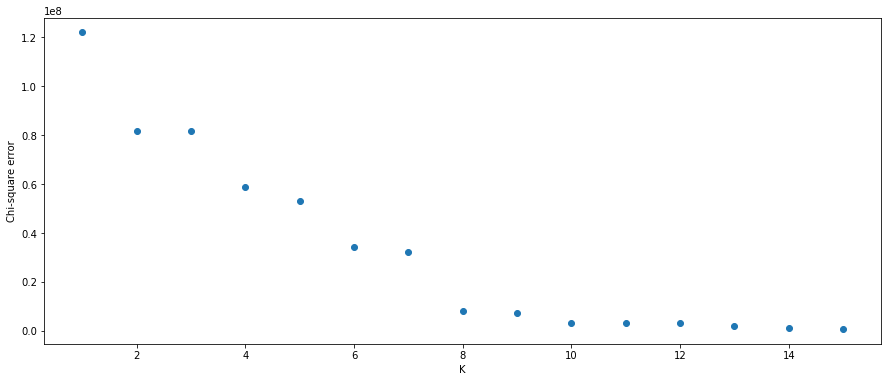

In [4]:

###### plot Chi-square(K) to make sure the function is decreasing when N = 20 #####

# generate N=20 samples with K_true=10 polynomials
N = 20
K_true = 10
x,y,sigma = poly_sample(N=20,K_true=10)
# get x: K_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  y: Chi-square
K_test = []
Chi_test = []
for t in range(K_true+5):
    K_test.append(t+1)
    Chi_test.append(Chi_square(N, x, y, K_test[t], sigma))
    
# plot K vs Chi-square
plt.figure(figsize=(15,6))
plt.plot(K_test, Chi_test, 'o')
plt.xlabel("K")
plt.ylabel("Chi-square error")
plt.savefig('3_b.png')

In [5]:
##################################################
#       (c) mean and variance of optimal K       #
##################################################
# function to select optimal K for 1 trial:
def optimal_K(x, y, sigma):
    
    K_set = []       # K_set = [1,2,3,...,K_true,K_true+1,...,K_true+5]
    BIC_set = []     # BIC_set = [BIC_1,BIC_2,...,BIC_K_True+5]
    for t in range(K_true):
        # generate set of K
        K_set.append(t+1)                         # K_set[t]: K
        
        # calculate BIC of each K
        Chi_sq = Chi_square(N, x, y, K_set[t], sigma)   # Chi_sq: arg(min)Chi-square
        BIC = Chi_sq + (K_set[t]+1)*np.log(N)
        
        # generate set of BIC
        BIC_set.append(BIC)
    
    # get the indext of the minumum BIC
    ID = BIC_set.index(min(BIC_set))
    # get the optimal K
    K_optimal = K_set[ID]
    
    return K_optimal #,BIC_set, K_set

In [6]:
# function to run T tials with N sample and calculate mean & variance of optimal K
def simulate_T(T, N, K_true):
    
    K_optimals = []     # store K_optimal for each trial
    trial = []          # store trial ID 
    
    # loop 200 times
    for t in range(T):
        trial.append(t)                       # trail = [0, 1, 2, 3, ..., 199]
        x, y, sigma = poly_sample(N,K_true)   # make N samples 
        K_optimal = optimal_K(x, y, sigma)    # select K_optimal
        K_optimals.append(K_optimal)          # store K_optimal in K_optimals
    
    # calculate mean of K_optimals:
    K_optimal_mean = np.mean(K_optimals)
    
    # calculate variance of K_optimals:
    K_optimal_var = np.var(K_optimals)
    
    return K_optimal_mean, K_optimal_var#,  K_optimals

In [8]:
# run 500 trials with N=20, K_true=10
K_optimal_mean, K_optimal_var = simulate_T(T=500, N=20, K_true=10)
print("The mean of optimal K over 500 trials is %s" % K_optimal_mean)
print("The varriance of optimal K over 500 trials is %s" % K_optimal_var)

The mean of optimal K over 500 trials is 9.99
The varriance of optimal K over 500 trials is 0.0139


In [9]:
##################################################
#           (d) plot optimal_K vs N              #
##################################################
# function to run T tials with N sample and calculate mean & variance of optimal K
def simulate_T_N(T, e_N_max, K_true):
    
    K_means = []                                          # y:   store K_mean for each trial
    K_vars = []                                           # bar: store K_var for each trial
    Ns = np.rint(3*np.logspace(0,e_N_max,40)).astype(int) # x:   store N in Ns
    
    for N in Ns:
        K_mean, K_var = simulate_T(T, N, K_true)  # mean & varriance of optimal K of 500 trials
        K_means.append(K_mean)                    # store K_mean in K_means
        K_vars.append(K_var)                      # store K_var in K_vars
    return K_means, K_vars, Ns


In [10]:
# do the final simulation
K_means, K_vars, Ns = simulate_T_N(T=500, e_N_max=4, K_true=10)

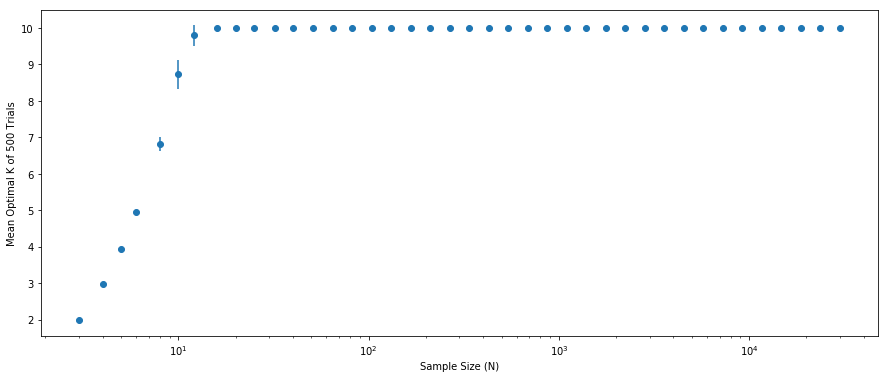

In [16]:
# plot mean of K with error bar vs. sample size N
plt.figure(figsize=(15,6))
plt.errorbar(Ns, K_means, yerr=K_vars, fmt='o')
plt.xlabel("Sample Size (N)")
plt.ylabel("Mean Optimal K of 500 Trials")
plt.xscale('log')
plt.savefig('3_d.png')
